In [21]:
# 导入需要用到的package
import numpy as np
import json
import matplotlib.pyplot as plt
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
data

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


array([6.320e-03, 1.800e+01, 2.310e+00, ..., 3.969e+02, 7.880e+00,
       1.190e+01])

In [22]:
# 读入之后的数据被转化成1维array，其中array的第0-13项是第一条数据，第14-27项是第二条数据，以此类推.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])

In [23]:
# 查看数据
x = data[0]
print(x.shape)
print(x)

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


In [24]:
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
training_data.shape

(404, 14)

In [25]:
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

In [26]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data,test_data,minimums[13],maximums[13]

Epoch   0 / iter   0, loss = 12.4815
Epoch   0 / iter   1, loss = 4.1831
Epoch   0 / iter   2, loss = 0.2040
Epoch   0 / iter   3, loss = 0.1761
Epoch   0 / iter   4, loss = 0.3379
Epoch   1 / iter   0, loss = 0.2353
Epoch   1 / iter   1, loss = 0.1551
Epoch   1 / iter   2, loss = 0.1460
Epoch   1 / iter   3, loss = 0.1684
Epoch   1 / iter   4, loss = 0.3293
Epoch   2 / iter   0, loss = 0.1362
Epoch   2 / iter   1, loss = 0.1478
Epoch   2 / iter   2, loss = 0.1250
Epoch   2 / iter   3, loss = 0.1123
Epoch   2 / iter   4, loss = 0.1559
Epoch   3 / iter   0, loss = 0.1985
Epoch   3 / iter   1, loss = 0.0869
Epoch   3 / iter   2, loss = 0.0799
Epoch   3 / iter   3, loss = 0.1127
Epoch   3 / iter   4, loss = 0.1423
Epoch   4 / iter   0, loss = 0.1235
Epoch   4 / iter   1, loss = 0.0870
Epoch   4 / iter   2, loss = 0.1083
Epoch   4 / iter   3, loss = 0.1272
Epoch   4 / iter   4, loss = 0.0648
Epoch   5 / iter   0, loss = 0.1442
Epoch   5 / iter   1, loss = 0.1648
Epoch   5 / iter   2, loss 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


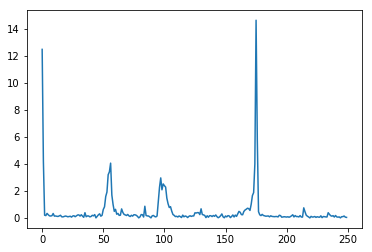

In [27]:
import numpy as np
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        # np.random.seed(0)
        self.w1 = np.random.randn(num_of_weights, num_of_weights)
        self.b1= 0.
        self.w2 = np.random.randn(num_of_weights, 1)
        self.b2 = 0.

    def forward(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        z1relu=np.maximum(z1,0)
        z =np.dot(z1relu,self.w2) + self.b2
        return z,z1relu,z1

    def loss(self, z, y):

        error = z - y

        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost

    def gradient(self, x, y):
        z,z1relu,z1= self.forward(x)
        N = x.shape[0]
        gradient_w2 = 1. / N * np.sum((z - y) * z1relu, axis=0)
        gradient_w2 = gradient_w2[:, np.newaxis]
        gradient_b2 = 1. / N * np.sum(z - y)
        gradient_w1 = 1. / N * np.sum((z - y) * z1relu * x, axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1 = 1. / N * np.sum((z - y)*(y-z1relu))
        
        return gradient_w1, gradient_b1,gradient_w2,gradient_b2

    def update(self, gradient_w1, gradient_b1,gradient_w2 ,gradient_b2,eta=0.01):
        self.w1 = self.w1 - eta * gradient_w1
        self.b1 = self.b1 - eta * gradient_b1
        self.w2 = self.w2 - eta * gradient_w2
        self.b2 = self.b2 - eta * gradient_b2
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                # print(self.w.shape)
                # print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a ,a1,a2= self.forward(x)
                loss = self.loss(a, y)
                gradient_w1, gradient_b1,gradient_w2,gradient_b2 = self.gradient(x, y)
                self.update(gradient_w1, gradient_b1,gradient_w2,gradient_b2, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                      format(epoch_id, iter_id, loss))

        return losses


# 获取数据
train_data, test_data,min,max= load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [28]:

x=test_data[-10,-1]
pred,pred1,pred2=net.forward(test_data[-10,:-1])
repred=(pred*max)-(min*(pred-1))
retest=(x*max)-(min*(x-1))
print("取倒数第十行数据测试实际值为",retest,"预测值为",repred)

取倒数第十行数据测试实际值为 19.7 预测值为 [29.26028117]
